# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i> <BR>
    
This course is based on specific versions of python packages. You can find the details of the same in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>. The manual also explains how to use these codes in other versions of python packages. <BR>

# Strategy Creation and Optimization

Every strategy boils down to this formula:
Gain Expectancy = Trading edge = Win% * avg win% - Loss% * abs(avg loss%)
This formula has two parts:
1. Signal module: win% and loss% 
2. Money management module: avg win% and avg loss%

In part 1 of this course, we have learned so far:
1. How to restate absolute prices relative to an index and a pivot currency
2. How to calculate returns and cumulative returns.
3. Several methods to define regime: breakout, moving averages crosses and floor & ceiling


In part 2, 
1. We will create a strategy by blending the three regime definition methodologies into a Long/Short strategy
2. We will define a few risk metrics that specifically test the robustness.
3. We will optimise over a few variables on a single security. This will conclude the signal module of the strategy
4. Finally, we will look at the money management side of the strategy with a few position sizing algorithms


This notebook is divided into two parts:
1. Strategy Creation
2. and, Strategy Optimization

## Strategy Creation
Objectives:
We want a regime definition that has the following attributes:
1. Stability: We do not want a jumpy method. This increases transaction costs, slippage. This excludes MA crosses. 
2. Limited lag: We want a strategy that identifies inflections as early as possible. This excludes breakouts. 
3. Weathers sideways markets: Market participants make money in the bull & bear markets, but end up giving back some in sideways markets. Our objective is to minimise drawdowns. 

By elimination, the Floor & Ceiling method seems to be the default candidate:
1. Floor/Ceiling is stable
2. Regime changes from bull to bear on a high and on a low for bear to bull
3. Floor/Ceiling does not react to range-bound markets where lows and highs are at similar levels


Next, we will focus on signals:
The logical candidate is short-term & mid-term moving averages cross. It enables us to enter a short as a bear market rally peters out and go long as market rallies.

Stop Loss:
A short-selling strategy would not be complete without a stop loss. It has a dual purpose:
1. Stop loss: it deals with the lag in MA and false positives swing detection
2. Position sizing: position size will be calculated from the stop loss to the close of the signal bar
Stop loss must, therefore, be close enough to the current price to warrant decent position size. This excludes floor and ceiling. The logical candidate is short term rolling max or min, the main ingredient in the breakout regime.

This combo strategy does not require a lag as the floor/ceiling method anymore. The inflection in the moving averages will lag the discovery of a swing.

## Import libraries

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd
from datetime import datetime

# Calculates swing highs and lows
from scipy.signal import *
from scipy.signal import argrelextrema

# Appends new file paths to import modules
import sys
sys.path.append("..")

# All functions library
from data_modules.short_selling import relative
from data_modules.short_selling import swings
from data_modules.short_selling import regime_fc
from data_modules.short_selling import returns
from data_modules.short_selling import sma
from data_modules.short_selling import cum_return_percent

# Imports charting libraries
import matplotlib.pyplot as plt
%matplotlib inline

# Construct a list of permutations
import itertools as it

## Import data
### Files name:
1. BAC_Jan_2010_to_Jan_2019.csv, contains stock data for 'Bank of America'
2. USDGBP_Jan_2010_to_Jan_2019.csv, contains forex data for 'USDGBP'
3. SP500_Jan_2010_to_Jan_2019.csv, contains benchmark data for 'SP500'

This data is available in the last unit of this course. You can find this file in the downloadables section of the course.

In [2]:
# Data is stored in the directory 'data_modules' 
relative_path = "../data_modules/"

In [3]:
# Read and process data
stock = pd.read_csv(relative_path +'BAC_Jan_2010_to_Jan_2019.csv',index_col=0, parse_dates=True)

In [4]:
# Import and read benchmark data using the function 'read_csv'
benchmark =pd.read_csv(relative_path + 
    'SP500_Jan_2010_to_Jan_2019.csv', index_col=0, parse_dates=True)

benchmark_name = 'SP500'

# Import and read forex data using the function 'read_data'
forex = pd.read_csv(relative_path + 
    'USDGBP_Jan_2010_to_Jan_2019.csv',index_col=0, parse_dates=True)

forex_name = 'USDGBP'

In [5]:
# Create a relative series
new = relative(stock_dataframe=stock, benchmark_dataframe=benchmark, benchmark_name='SP500',
               forex_dataframe=forex, forex_name='USDGBP', decimals=2, start=None, end=None)

# Calculate the swings
new = swings(df=new, high='rebased_high', low='rebased_low', argrel_window=20)

# Calculate the stock regime
new = regime_fc(df=new, close='rebased_close', swing_low='srebased_low',
                swing_high='srebased_high', threshold=1.5, t_dev=63, decimals=3)

# Returns the last two rows of the dataframe
new.tail(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,...,rebased_low,rebased_close,srebased_low,srebased_high,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,24.57,24.97,24.37,24.64,0.79,249.92,196.32,0.13,0.13,0.12,...,8.73,8.83,NaN,NaN,NaN,NaN,10.38,-1.0,11.94,-1.0
2019-01-02,24.08,25.14,24.01,24.96,0.80,250.18,200.63,0.12,0.13,0.12,...,8.42,8.75,NaN,NaN,NaN,NaN,10.38,-1.0,11.94,-1.0


### Strategy:
To recap, our strategy will enter:
1. Long when regime == 1 and moving average st>=mt
2. Short when regime ==-1 and moving average st<=mt
It will exit:
1. Long when regime == 1 and moving average st < mt
2. Short when regime ==-1 and moving average st > mt

Stop Loss will be set at: 
1. Long highest high over mt 
2. Short lowest low over mt


#### Strategy creation : 'signal_fcstmt'

This function 'signal_fcstmt' calculates positions based on regime & ma crossover. This function over imposes st/mt moving average cross condition on the regime. It will take an active position only if the regime and moving averages are aligned.
Conditions:
1. Long : st-mt > 0 & regime == 1
2. Short: st-mt < 0 & regime == -1

In [6]:
def signal_fcstmt(regime,st,mt):

    # Calculate the sign of the stmt delta
    stmt_sign = np.sign((st - mt).fillna(0))

    # Calculate entries/exits based on regime and stmt delta
    active = np.where( np.sign( regime* stmt_sign) == 1,1,np.nan)
    signal = regime * active

    return signal

#### Strategy creation : 'stop_loss'
 
This function 'stop_loss' uses signals generated from the previously defined function and swings to calculate stop loss.
1. Join swing lows/highs, only keeps the value of the first day of signal (to avoid reset).
2. Find the cumulative lowest/highest close.
3. If close breaches stop loss, then crop signal column: np.nan 
4. Thereafter, return stop-loss column  

In [7]:
def stop_loss(signal, close, s_low, s_high):

    # Stop loss calculation
    stoploss = (s_low.add(s_high, fill_value=0)).fillna(
        method='ffill')  # join all swings in 1 column
    stoploss[~((np.isnan(signal.shift(1))) & (~np.isnan(signal)))
             ] = np.nan  # keep 1st sl by signal
    # Extend first value with fillna
    stoploss = stoploss.fillna(method='ffill')

    # Bull: lowest close, Bear: highest close
    close_max = close.groupby(stoploss).cummax()
    close_min = close.groupby(stoploss).cummin()
    cum_close = np.where(signal == 1, close_min,
                         np.where(signal == -1, close_max, 0))

    # Reset signal where stop loss is breached
    sl_delta = (cum_close - stoploss).fillna(0)
    sl_sign = signal * np.sign(sl_delta)
    signal[sl_sign == -1] = np.nan

    return stoploss

#### Strategy creation: 'transaction_costs'

This function 'transaction_costs' identifies entries and exits by subtracting position column one row up .diff(). To avoid any residuals na, fillna() is done before subtraction. Transaction costs are deducted from the daily returns before compounding and then this daily returns column is adjusted.

In [8]:
def transaction_costs(df, position_column, daily_return, tcs):

    # Boolean filter
    inout = df[position_column].fillna(0).diff().fillna(0) != 0
    df[daily_return] = np.where(
        inout, df[daily_return] - float(tcs), df[daily_return])

    return df[daily_return]

# Strategy optimization

Now that we have created the strategy, the first question that comes to mind is which combinations of st and mt moving averages are going to produce returns over the higher of either passive or regime relative returns.

In this section:

We,
1. Calculate the relative and absolute returns
2. Create a list of st/mt permutations
3. Loop through the st/mt permutations

Steps within the for loop:
​
1. Calculate moving average crossovers
2. Calculate positions based on the regime and moving average crossovers
3. Calculate daily & cumulative returns and include transaction costs
4. Calculate excess returns for passive and regime strategies 
5. Calculate the cumulative performance
6. If Cumulative> Hurdle(max of passive/regime), then append a list to the dictionary.
7. Plot the graph

### Calculate relative and absolute returns

In [9]:
# Calculate returns for the relative closed price
new['r_return_1d'] = returns(new['rebased_close'])
# Calculate returns for the absolute closed price
new['return_1d'] = returns(new['Close'])

In [10]:
# Return the last two rows of the dataframe
new.tail(2)

,Open,High,Low,Close,USDGBP,SP500,adjustment_factor,relative_open,relative_high,relative_low,...,srebased_low,srebased_high,r_floor,r_ceiling,r_regime_change,r_regime_floorceiling,r_floorceiling,r_regime_breakout,r_return_1d,return_1d
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,24.57,24.97,24.37,24.64,0.79,249.92,196.32,0.13,0.13,0.12,...,NaN,NaN,NaN,NaN,10.38,-1.0,11.94,-1.0,0.004540,0.010198
2019-01-02,24.08,25.14,24.01,24.96,0.80,250.18,200.63,0.12,0.13,0.12,...,NaN,NaN,NaN,NaN,10.38,-1.0,11.94,-1.0,-0.009101,0.012903


In [11]:
# Declare the variables
st_list = range(10, 101, 10)
mt_list = range(160, 201, 20)

tcs = 0.0025
lag = 9

### Construct a list of short_term/mid_term permutations

In [12]:
# Construct a list of st mt permutations
permutations = it.product(st_list, mt_list)
# Print the number of st/mt permutations
print('number of short_term/mid_term permutations: ', len(list(permutations)))

number of short_term/mid_term permutations:  30


In [13]:
# Create a dataframe and dictionary list
list_dict = []

perf = pd.DataFrame()
returns = pd.DataFrame()

### Loop over st/mt permutations

In [14]:
# st stands for short_term and mt stands for mid_term
for st, mt in it.product(st_list, mt_list):
    if st < mt:
        # Create dataframe
        data = pd.DataFrame()
        data[['rebased_close', 'Close', 'r_return_1d', 'return_1d', 'r_regime_floorceiling', 'srebased_low', 'srebased_high']] = \
            new[['rebased_close', 'Close', 'r_return_1d', 'return_1d',
                 'r_regime_floorceiling', 'srebased_low', 'srebased_high']].copy()

        # Calculate moving averages
        st_mt = str(st)+'_'+str(mt)
        r_st_ma = sma(df=data, price='rebased_close',
                      ma_per=st, min_per=1, decimals=2)
        r_mt_ma = sma(df=data, price='rebased_close',
                      ma_per=mt, min_per=1, decimals=2)

        # Calculate positions based on regime and moving average crossovers
        data['s'+'_'+st_mt] = signal_fcstmt(
            regime=data['r_regime_floorceiling'], st=r_st_ma, mt=r_mt_ma)
        data['stop_loss'+'_'+st_mt] = stop_loss(signal=data['s'+'_'+st_mt],
                                    close=data['rebased_close'],
                                    s_low=data['srebased_low'],
                                    s_high=data['srebased_high'])

        # Calculate daily & cumulative returns and include transaction costs
        data['d'+'_'+st_mt] = data['r_return_1d'] * data['s'+'_'+st_mt].shift(1)
        data['d'+'_'+st_mt] = transaction_costs(
            df=data, position_column='s'+'_'+st_mt, daily_return='d'+'_'+st_mt, tcs=tcs)
        data['c'+'_'+st_mt] = round(cum_return_percent(data['d'+'_'+st_mt].fillna(0)), 3)

        # Date of initial position to calculate excess returns for passive and regime strategies
        first_position_date = data[pd.notnull(data['s'+'_'+st_mt])].index[0]
        data_sliced = data[first_position_date:].copy()

        # Cumulative performance must be higher than either passive or regime (w/o transaction costs)
        passive = round(cum_return_percent(data_sliced['r_return_1d'])[-1], 3)
        fc_perf = round(cum_return_percent(
            data_sliced['r_return_1d'] * data['r_regime_floorceiling'].shift(lag))[-1], 3)
        hurdle = np.maximum(passive, fc_perf)

        # If cumulative returns > hurdle, append list_dict and returns
        if data['c'+'_'+st_mt][-1] >= hurdle:
            returns[st_mt] = data['c'+'_'+st_mt]
            # a) create row dictionary
            row = {'st_mt': st_mt, 'st': st, 'mt': mt,
                   'perf': data['c'+'_'+st_mt][-1], 'passive': passive}
            # b) append list_dict
            list_dict.append(row)
    else:
        pass

In [15]:
# Create a dataframe from dictionary
perf =  pd.DataFrame.from_dict(list_dict)
# Sort by perf in descending order
perf.sort_values(by=['perf'],ascending=False,inplace=True) 
# Re-order columns
perf = perf[['st_mt', 'st','mt','perf','passive']] 
perf[:10]

,st_mt,st,mt,perf,passive
6,30_180,30,180,481.3,-33.2
9,40_180,40,180,454.3,-33.2
12,50_180,50,180,387.8,-33.2
5,30_160,30,160,369.5,-33.8
15,60_180,60,180,356.1,-33.2
3,20_180,20,180,350.8,-33.2
13,50_200,50,200,342.3,-23.5
8,40_160,40,160,338.9,-33.8
10,40_200,40,200,335.9,-23.5
11,50_160,50,160,334.9,-33.8


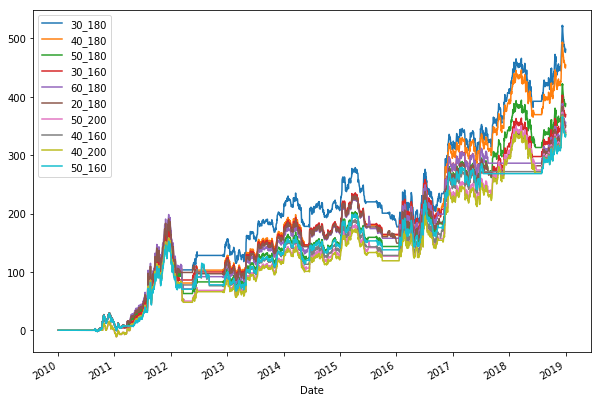

In [16]:
# Sort returns dataframe and plot top 10 combinations
plot_cols = 10
returns.sort_values(by=returns.index.max(),
                    ascending=False, axis=1, inplace=True)
# Plot the graph against stmt
returns[returns.columns[:10]].plot(figsize=(10, 7))